In [1]:
# Code for time series prediction using LSTM model

# Import required modules
from math import sqrt
from numpy import concatenate

# For plotting
from matplotlib import pyplot

# For data preprocessing
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# Machine learning library 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import model_from_json

import pylab as pl
%pylab inline 

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


c:\users\budhk\appdata\local\programs\python\python36\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Specify the number of lag hours
n_hours = 6
n_features = 163

c:\users\budhk\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 160000 samples, validate on 50878 samples
Epoch 1/50
 - 14s - loss: 2.7529 - val_loss: 0.3555
Epoch 2/50
 - 12s - loss: 0.3565 - val_loss: 0.4866
Epoch 3/50
 - 11s - loss: 0.3131 - val_loss: 0.2161
Epoch 4/50
 - 12s - loss: 0.2877 - val_loss: 0.2148
Epoch 5/50
 - 12s - loss: 0.3452 - val_loss: 0.2266
Epoch 6/50
 - 12s - loss: 0.2803 - val_loss: 0.1539
Epoch 7/50
 - 12s - loss: 0.2765 - val_loss: 0.1631
Epoch 8/50
 - 11s - loss: 0.2599 - val_loss: 0.2421
Epoch 9/50
 - 11s - loss: 0.3196 - val_loss: 0.2614
Epoch 10/50
 - 11s - loss: 0.2386 - val_loss: 0.5396
Epoch 11/50
 - 11s - loss: 0.2673 - val_loss: 0.5459
Epoch 12/50
 - 11s - loss: 0.2705 - val_loss: 0.6341
Epoch 13/50
 - 12s - loss: 0.2675 - val_loss: 0.3637
Epoch 14/50
 - 12s - loss: 0.2805 - val_loss: 0.2201
Epoch 15/50
 - 11s - loss: 0.2857 - val_loss: 0.2652
Epoch 16/50
 - 12s - loss: 0.2937 - val_loss: 0.1672
Epoch 17/50
 - 12s - loss: 0.2648 - val_loss: 0.2121
Epoch 18/50
 - 12s - loss: 0.2587 - val_loss: 0.1483
Epoc

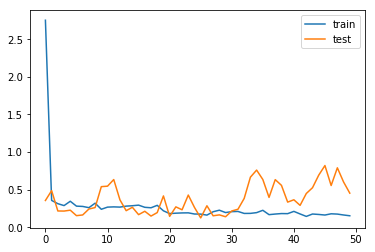

Predicted
[[-0.02927437]
 [ 2.9093533 ]
 [ 4.9459286 ]
 ...
 [ 2.228824  ]
 [20.622812  ]
 [20.667145  ]]
Expected
[ 0  3  5 ...  2 20 20]
Test RMSE: 28.465
Saved model to disk
Loaded model from disk


8

In [4]:
# Split into train and test sets
n_train_hours = 160000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, 1:], train[:, 1]
test_X, test_y = test[:, 1:], test[:, 1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# For testing
test1_X = test_X[1]
test1_X = test1_X.reshape((test1_X.shape[0], 1, test1_X.shape[1]))

# Network definition
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# Prediction
yhat = model.predict(test_X)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
print("Predicted")
print(yhat)
yhat1=pd.DataFrame(yhat[-20:])
print("Expected")
print(test_y)

test_y1=pd.DataFrame(test_y[-20:])
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# Serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

loaded_model = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
yhat = model.predict(test1_X)
rmse=rmse/50000*20
# Save output to file
f= open("out.txt","a+")
f.write("%d" %int(yhat))
f= open("out_rmse.txt","a+")
f.write("%f" %rmse)

Text(0.5,1,'RMSE Error')

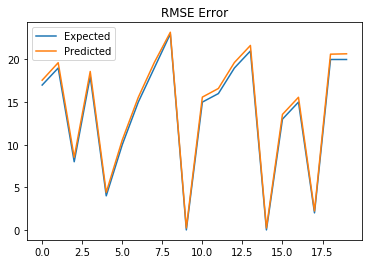

In [8]:
pl.plot(test_y1,label='Expected')
pl.plot(yhat1,label='Predicted')
pl.legend()
pl.title('RMSE Error')